In [10]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import glob
import numpy as np
import os

%load_ext autoreload
%autoreload 2
import sys

sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

sys.path.insert(1, '../../clust')
import clustering_statistics as cs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
training_dir_base = '/home/users/ksf293/clust/results_aemulus_train'
plot_dir = '../plots/plots_2022-05-02'
!mkdir -p $plot_dir

## Test out effect of pi_max

In [3]:
id_pairs = np.loadtxt('../tables/id_pairs_train.txt', delimiter=',', dtype=int)

In [4]:
idx = 46
id_pair = id_pairs[idx]
cosmo_id = id_pair[0]
hod_id = id_pair[1]
test = 0
L = 1050.0
redshift = 0.55
mock_dir = '/mount/sirocco2/zz681/emulator/CMASSLOWZ/galaxy_mocks/mocks'
mock_name = f'mock_cosmo_{cosmo_id}_HOD_{hod_id}_test_{test}.mock'
fn_mock = f'{mock_dir}/{mock_name}'

In [5]:
def real_to_zspace(position, velocity, L, redshift, Omega_m, w):
    position = np.array(position)
    velocity = np.array(velocity)
    E = np.sqrt(Omega_m*(1+redshift)**3 +
                (1-Omega_m)*(1+redshift)**(3*(1+w)))
    position = (position + velocity*(1+redshift)/(E*100))%L
    return position

In [6]:
print("Loading data")
x, y, z, _, _, vz = np.loadtxt(fn_mock, usecols=range(6), unpack=True)

print("Get cosmology values")
cosmofn = '/mount/sirocco1/zz681/emulator/CMASS/Gaussian_Process/hod_file/cosmology_camb_full.dat'
Omega_ms, ws = np.loadtxt(cosmofn, usecols=[0, 6], unpack=True)
Omega_m = Omega_ms[cosmo_id]
w = ws[cosmo_id]
print(Omega_m, w)
print("Converting to redshift space along z-axis")
z = real_to_zspace(z, vz, L, redshift, Omega_m, w)

Loading data
Get cosmology values
0.340563 -0.8165972
Converting to redshift space along z-axis


In [7]:
sigma_8s = np.loadtxt(cosmofn, usecols=2, unpack=True)

In [8]:
from Corrfunc.theory.wp import wp
nthreads = 1
r_min, r_max = 0.1, 50.0
n_bins = 9
r_bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1) # Note the + 1 to nbins
r_avg = 10 ** (0.5 * (np.log10(r_bins)[1:] + np.log10(r_bins)[:-1]))

In [9]:
pi_max = 40.0
res = wp(L, pi_max, nthreads, r_bins, x, y, z)
print(res['wp'])

[3.67927133e+03 1.59917199e+03 6.06213554e+02 1.83157832e+02
 6.65026214e+01 3.40276837e+01 1.85135307e+01 8.89195491e+00
 3.02614564e+00]


In [10]:
pi_max = 80.0
res = wp(L, pi_max, nthreads, r_bins, x, y, z)
wp_80 = res['wp']
print(wp_80)

[3.67349284e+03 1.59245332e+03 6.03352456e+02 1.82770020e+02
 6.61740210e+01 3.35643730e+01 1.75975597e+01 7.97356703e+00
 2.43551312e+00]


In [11]:
wp_arr = []
pi_max_arr = np.arange(10.0, 130.0, 10.0)
r_min, r_max = 0.1, 50
n_bins = 9
fn_save = '/tmp/wp.dat'
for pi_max in pi_max_arr:
    r_avg, wp = cs.compute_wprp(x, y, z, L, r_min, r_max, n_bins, fn_save, pi_max=pi_max)
    wp_arr.append(wp)
    
wp_arr = np.array(wp_arr)
wp_40 = wp_arr[np.where(pi_max_arr==40.0)[0][0]]

Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving
Computing wp(rp)
Saving


In [12]:
from Corrfunc.theory.wp import wp

wp_arr = []
pi_max_arr = np.arange(10.0, 130.0, 10.0)
r_min, r_max = 0.1, 50
n_bins = 9

nthreads = 1
r_bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1) # Note the + 1 to nbins    
    
for pi_max in pi_max_arr:
    res = wp(L, pi_max, nthreads, r_bins, x, y, z)
    wp_arr.append(res['wp'])
    
wp_arr = np.array(wp_arr)
wp_40 = wp_arr[np.where(pi_max_arr==40.0)[0][0]]

Text(0.5, 1.0, 'Training sample: cosmo 0, HOD 46')

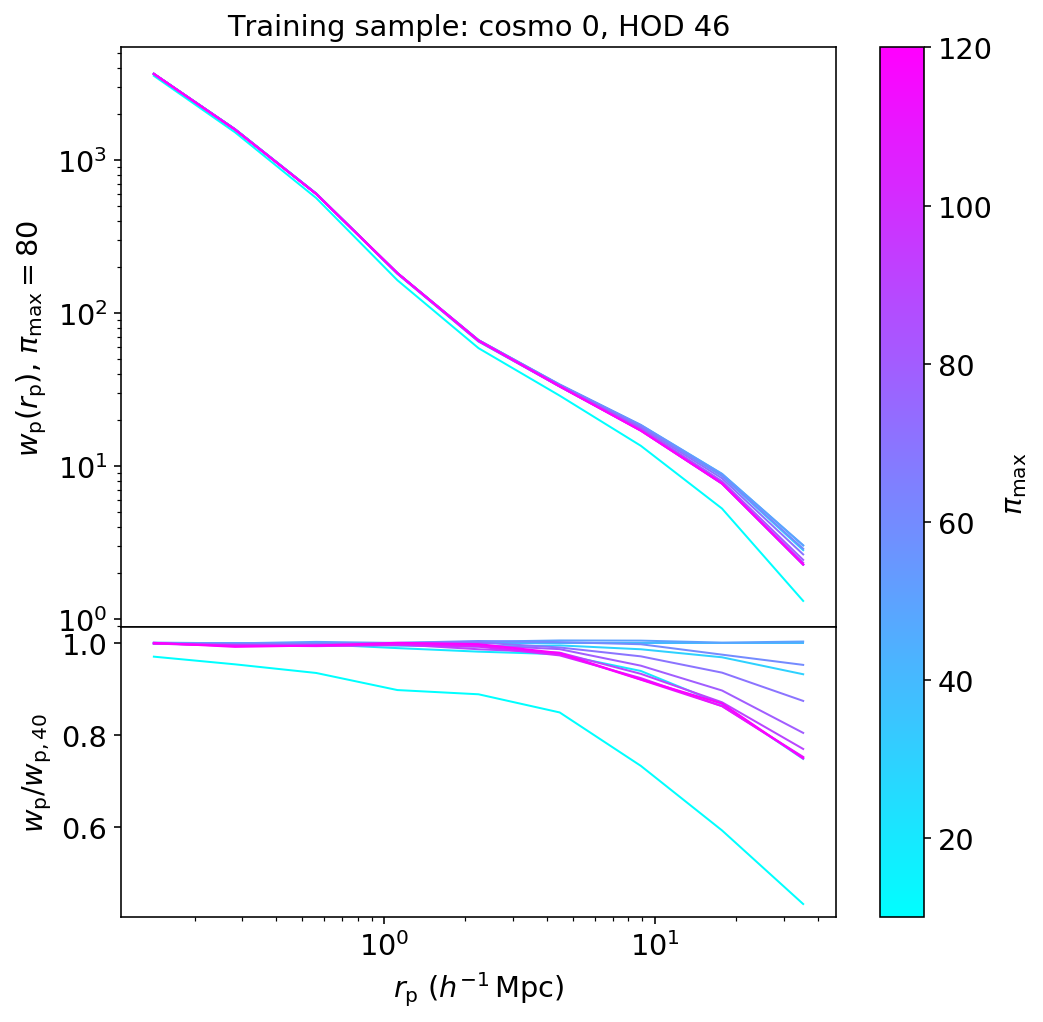

In [13]:
statistic = 'wp80'

fig, axarr = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)
ax0, ax1 = axarr
#for i in range(len(y_train_arr)):

locs_norm = matplotlib.colors.Normalize(vmin=np.min(pi_max_arr), vmax=np.max(pi_max_arr))
cmap = matplotlib.cm.get_cmap('cool')

for i, pi_max in enumerate(pi_max_arr):
    ax0.plot(r_avg, wp_arr[i], color=cmap(locs_norm(pi_max)), alpha=1, lw=1)
    ax1.plot(r_avg, wp_arr[i]/wp_40, color=cmap(locs_norm(pi_max)), alpha=1, lw=1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
fig.colorbar(sm, label=r'$\pi_\mathrm{max}$', ax=axarr.ravel().tolist(),)


ax0.set_xscale(scale_dict[statistic][0])
ax0.set_yscale(scale_dict[statistic][1])

ax1.set_xscale(scale_dict[statistic][0])

ax1.set_xlabel(r_labels[statistic])
ax0.set_ylabel(stat_labels[statistic])
ax1.set_ylabel(r'$w_{\mathrm{p}} / w_{\mathrm{p},40}$')

ax0.set_title(f'Training sample: cosmo {cosmo_id}, HOD {hod_id}')

In [14]:
from Corrfunc.theory import DDrppi
from Corrfunc.utils import convert_3d_counts_to_cf

In [15]:
N = len(x)
N_rand = N*3
rand_X, rand_Y, rand_Z = np.random.uniform(size=(3,N_rand))*L

In [16]:
pimax = 80
nthreads = 1
autocorr = 1
DD_counts = DDrppi(autocorr, nthreads, pimax, r_bins, x, y, z,
                 periodic=True, verbose=False)

# Cross pair counts in DR
autocorr=0
DR_counts = DDrppi(autocorr, nthreads, pimax, r_bins, x, y, z,
                   X2=rand_X, Y2=rand_Y, Z2=rand_Z,
                  periodic=True, verbose=False)

# Auto pairs counts in RR
autocorr=1
RR_counts = DDrppi(autocorr, nthreads, pimax, r_bins, rand_X, rand_Y, rand_Z,
                   periodic=True, verbose=False)

In [17]:
dd = DD_counts

In [18]:
nbins = len(r_bins) - 1
npibins = int(len(DD_counts['npairs'])/nbins)
print(nbins, npibins)

9 80


In [19]:
print(DD_counts.dtype)
print(DD_counts[:2])


[('rmin', '<f8'), ('rmax', '<f8'), ('rpavg', '<f8'), ('pimax', '<f8'), ('npairs', '<u8'), ('weightavg', '<f8')]
[(0.1, 0.19947366, 0., 1., 3404, 0.) (0.1, 0.19947366, 0., 2., 2876, 0.)]


In [20]:
dd = np.array(DD_counts['npairs'])
dd.resize((nbins, npibins))

dr = np.array(DR_counts['npairs'])
dr.resize((nbins, npibins))

rr = np.array(RR_counts['npairs'])
rr.resize((nbins, npibins))

In [21]:
nonzero = rr > 0

fN = np.float64(N_rand) / np.float64(N)
cf = np.zeros((nbins, npibins))
cf[:] = np.nan
cf[nonzero] = (fN * fN * dd[nonzero] -
               2 * fN * dr[nonzero] +
               rr[nonzero]) / rr[nonzero]

In [22]:
np.min(np.abs(cf[cf < 0]))

3.365068628231904e-05

Text(0.5, 0, '$r_\\mathrm{p}$')

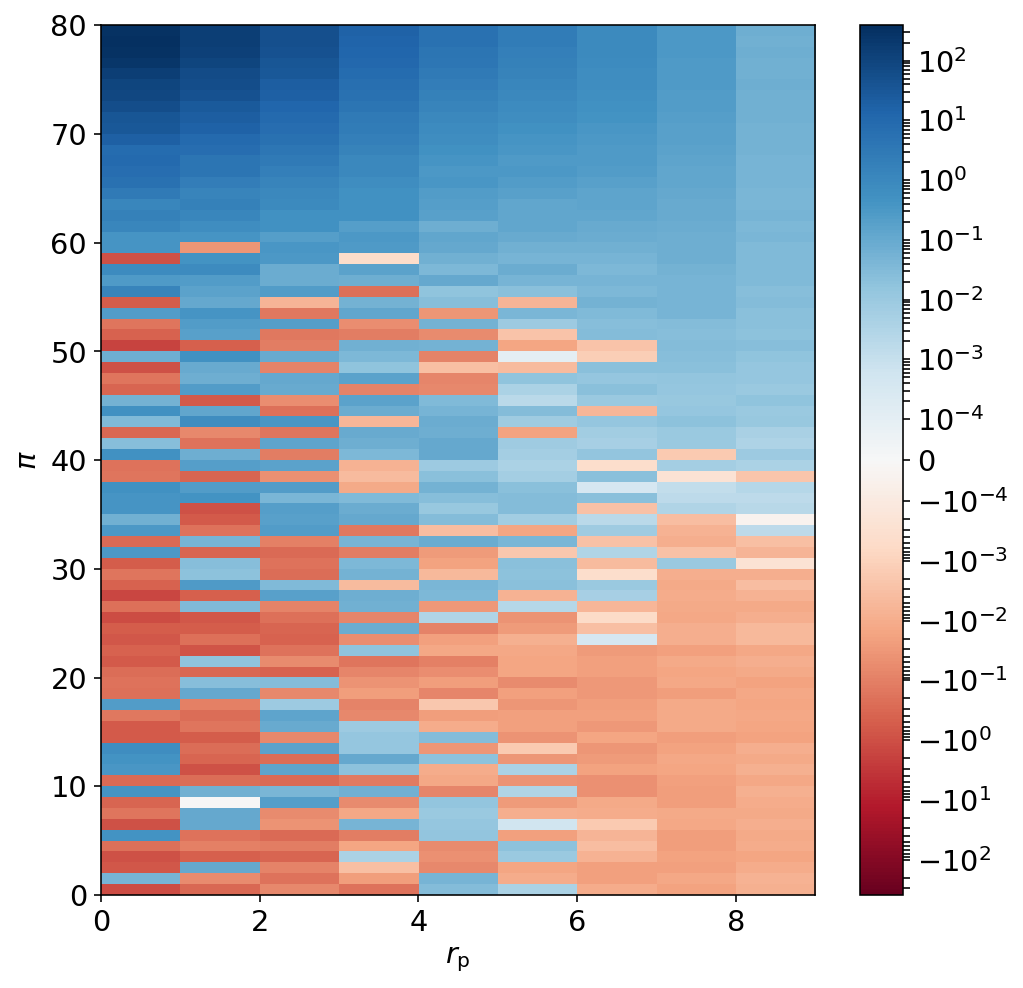

In [23]:
from matplotlib import colors
plt.figure(figsize=(8,8))
logthresh = 4
plt.imshow(cf.T, extent=[0,9,0,80], aspect='auto', norm=colors.SymLogNorm(10**-logthresh), cmap='RdBu', 
           vmin=-np.max(cf), vmax=np.max(cf))
plt.colorbar()
plt.ylabel(r'$\pi$')
plt.xlabel(r'$r_\mathrm{p}$')

In [25]:
# statistic_wp = 'wp'
# training_dir_wp = f'{training_dir_base}/results_{statistic_wp}'
# fn_y = f'{statistic}_cosmo_{cosmo_id}_HOD_{hod_id}_test_0.dat'
# r_vals, y = np.loadtxt(os.path.join(training_dir_wp, fn_y), delimiter=',', unpack=True)
# print(y)

In [26]:
# print(wp_40)
# print(y_train_arr_wp[idx])
# print()
# print(wp_80)
# print(y_train_arr[idx])
# print()
# print(y_train_arr[idx]/y_train_arr_wp[idx])
# print(id_pairs[idx])

The saved value is different than the value computed here for wp with pi_max=40. need to figure out!!

## Check out all of them

In [27]:
statistic_wp = 'wp'
training_dir_wp = f'{training_dir_base}/results_{statistic_wp}'
id_pairs = np.loadtxt('../tables/id_pairs_train.txt', delimiter=',', dtype=int)

r_arr_wp = []
y_train_arr_wp = []
for id_pair in id_pairs:
    cosmo_id, hod_id = id_pair
    fn_y_train = f'{statistic_wp}_cosmo_{cosmo_id}_HOD_{hod_id}_test_0.dat'
    r_vals, y_train = np.loadtxt(os.path.join(training_dir_wp, fn_y_train), delimiter=',', unpack=True)
    r_arr_wp.append(r_vals)
    y_train_arr_wp.append(y_train)
r_arr_wp = np.array(r_arr_wp)
y_train_arr_wp = np.array(y_train_arr_wp)
print(y_train_arr_wp.shape)

(4000, 9)


In [28]:
statistic = 'wp80'
training_dir = f'{training_dir_base}/results_{statistic}'
id_pairs = np.loadtxt('../tables/id_pairs_train.txt', delimiter=',', dtype=int)
r_arr = []
y_train_arr = []
for id_pair in id_pairs:
    cosmo_id, hod_id = id_pair
    fn_y_train = f'{statistic}_cosmo_{cosmo_id}_HOD_{hod_id}_test_0.dat'
    r_vals, y_train = np.loadtxt(os.path.join(training_dir, fn_y_train), delimiter=',', unpack=True)
    r_arr.append(r_vals)
    y_train_arr.append(y_train)
r_arr = np.array(r_arr)
y_train_arr = np.array(y_train_arr)
print(y_train_arr.shape)

(4000, 9)


In [29]:
testing_dir_base = '/home/users/ksf293/clust/results_aemulus_test'
statistic = 'wp80'
testing_dir = f'{testing_dir_base}/results_{statistic}'

#fns_y_test = os.listdir(testing_dir)
id_pairs_test = np.loadtxt('../tables/id_pairs_test.txt', delimiter=',', dtype=int)
boxes = np.arange(5)
r_test_arr = []
y_test_arr = []
for id_pair in id_pairs_test:
    for box in boxes:
        cosmo_id, hod_id = id_pair
        fn_y_test = f'{statistic}_cosmo_{cosmo_id}_Box_{box}_HOD_{hod_id}_test_0.dat'
        r_vals, y_test = np.loadtxt(os.path.join(testing_dir, fn_y_test), delimiter=',', unpack=True)
        r_test_arr.append(r_vals)
        y_test_arr.append(y_test)
r_test_arr = np.array(r_test_arr)
y_test_arr = np.array(y_test_arr)
print(y_test_arr.shape)

(3500, 9)


In [30]:
def plot_wprp(statistic, r_arr, y_arr, ylabel_note='', fn_save=None):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    r = r_arr[0] #assume all r's are the same
    for i in range(len(y_arr)):
        plt.plot(r, y_arr[i], color='grey', alpha=0.2, lw=0.5)
    y_mean = np.mean(y_arr, axis=0)
    plt.plot(r, y_mean, color='k', lw=2, label='mean measurement')

    plt.xscale(scale_dict[statistic][0])
    plt.yscale(scale_dict[statistic][1])
    
    plt.xlabel(r_labels[statistic])
    plt.ylabel(stat_labels[statistic] + ylabel_note)
    
    handles, labels = ax.get_legend_handles_labels()
    line = Line2D([0], [0], color='grey', label='measurement on unique\ncosmo+HOD model', lw=0.5)
    handles.insert(0,line) 
    plt.legend(handles=handles, loc='best', fontsize=12)
    if fn_save is not None:
        plt.savefig(f'{plot_dir}/{fn_save}.png', bbox_inches='tight')

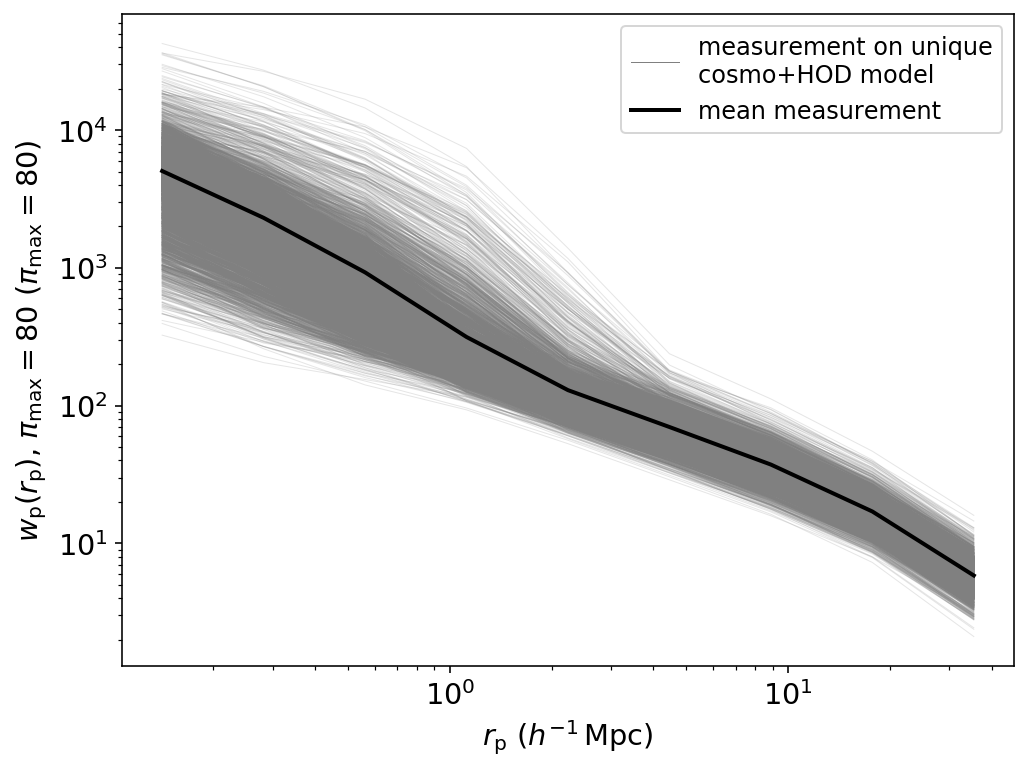

In [31]:
#fn_save = f'{statistic}_training'
fn_save = None
plot_wprp(statistic, r_arr, y_train_arr, ylabel_note=r' ($\pi_\mathrm{max}=80$)', fn_save=fn_save)

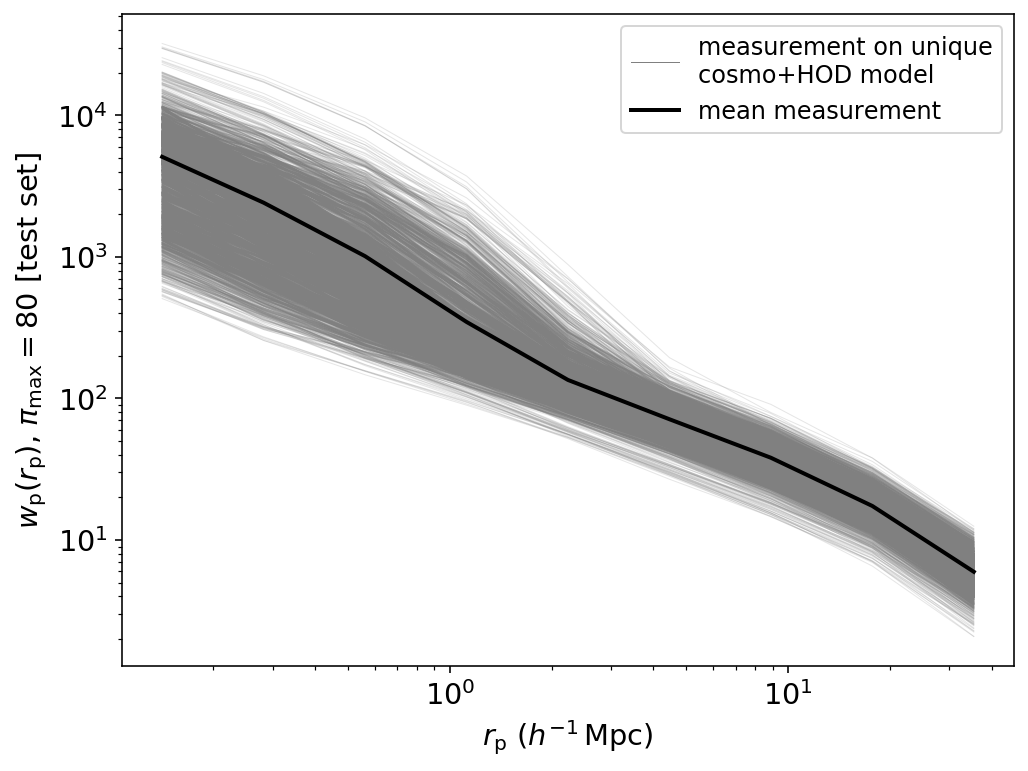

In [32]:
#fn_save = f'{statistic}_testing'
fn_save = None
plot_wprp(statistic, r_test_arr, y_test_arr, ylabel_note=r' [test set]', fn_save=fn_save)

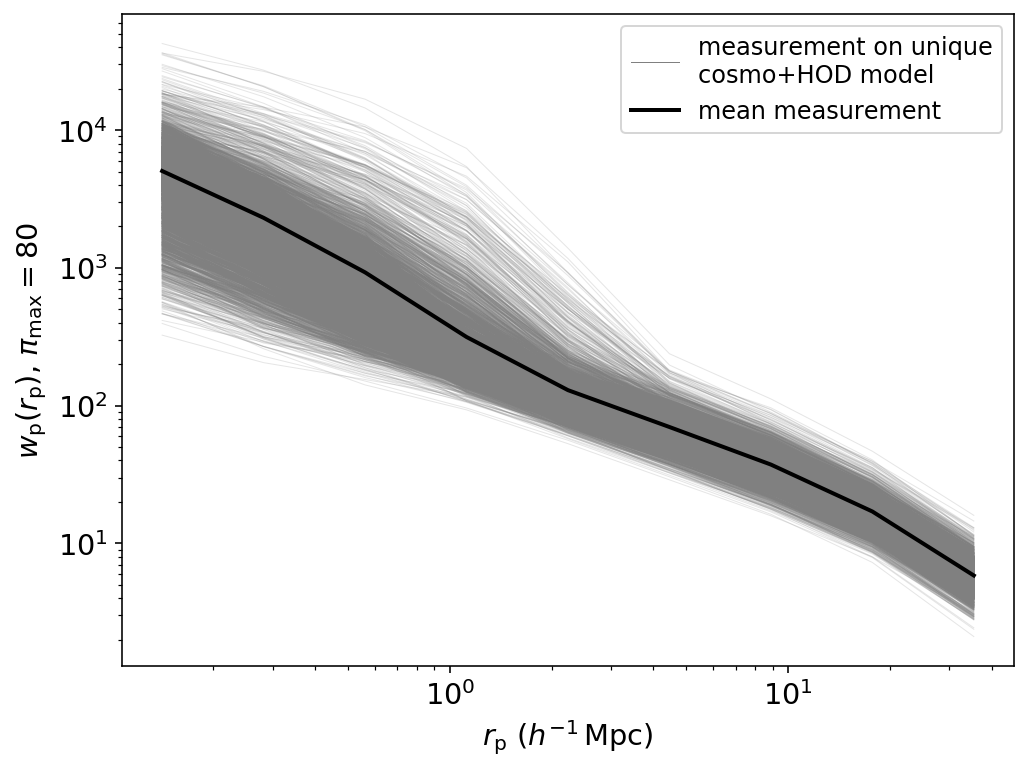

In [33]:
#fn_save = f'{statistic}_training'
fn_save = None
plot_wprp(statistic, r_arr, y_train_arr, fn_save=fn_save)

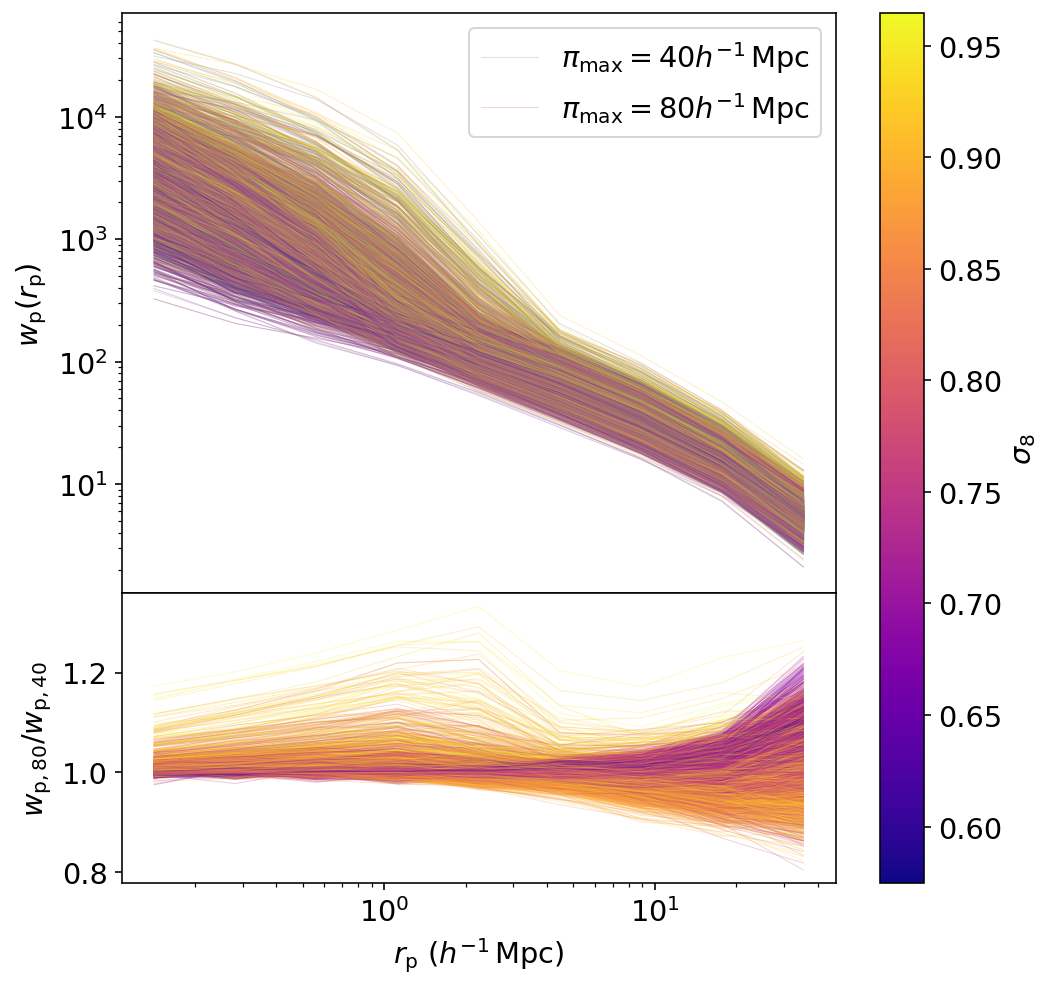

In [34]:
#ids_cosmo_unique = set(id_pairs[:,0])
#color_idx = np.linspace(0, 1, len(ids_cosmo_unique))

locs_norm = matplotlib.colors.Normalize(vmin=np.min(sigma_8s), vmax=np.max(sigma_8s))
cmap = matplotlib.cm.get_cmap('plasma')

fig, axarr = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)
ax0, ax1 = axarr
r = r_arr[0] #assume all r's are the same

n_train = len(y_train_arr)
rand_ints = np.random.randint(0, n_train, size=n_train)

for i in range(n_train):
#for i in range(1):
    label_40, label_80 = None, None
    if i==0:
        label_40=r'$\pi_\mathrm{max}=40 h^{-1}\,\mathrm{Mpc}$'
        label_80=r'$\pi_\mathrm{max}=80 h^{-1}\,\mathrm{Mpc}$'
    ax0.plot(r, y_train_arr_wp[i], color='grey', alpha=0.25, lw=0.5, 
             label=label_40, zorder=rand_ints[i])
    
    cosmo_id, hod_id = id_pairs[i]
    sig8 = sigma_8s[cosmo_id]
    color = cmap(locs_norm(sig8))
    
    ax0.plot(r, y_train_arr[i], color=color, alpha=0.25, lw=0.5, 
             label=label_80, zorder=rand_ints[i])
    ratio = y_train_arr[i]/y_train_arr_wp[i]
    ax1.plot(r, ratio, color=color, alpha=0.25, lw=0.5, zorder=rand_ints[i])

ax0.set_xscale(scale_dict[statistic_wp][0])
ax0.set_yscale(scale_dict[statistic_wp][0])

ax1.set_xscale(scale_dict[statistic_wp][0])

ax1.set_xlabel(r_labels[statistic_wp])
ax0.set_ylabel(stat_labels[statistic_wp])
ax1.set_ylabel(r'$w_{\mathrm{p},80} / w_{\mathrm{p},40}$')

ax0.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
fig.colorbar(sm, label=r'$\sigma_8$', ax=axarr.ravel().tolist())

In [35]:
print(r)
ratio = y_train_arr/y_train_arr_wp
print(ratio.shape)
print(np.where(ratio[:,8]<0.85))
print(np.where(ratio[:,3]>1.25))
print(len(np.where(ratio[:,8]<1)[0]))
print(len(np.where(ratio[:,3]>1.1)[0]))

[ 0.141235  0.281727  0.561971  1.120984  2.236068  4.460367  8.897257
 17.747683 35.401953]
(4000, 9)
(array([  46,   58,   85,  508,  510,  530,  545, 1093, 1406]),)
(array([ 506, 1418, 2816, 2820, 3114]),)
1288
81


## Check out HODs of ones with wp80(rp=1) / wp40(rp=1) > 1.1

In [149]:
hod_param_names = ['M_sat',
 'alpha',
 'M_cut',
 'sigma_logM',
 'v_bc',
 'v_bs',
 'c_vir',
 'f',
 'f_env',
 'delta_env',
 'sigma_env']

In [150]:
hodfn = '../tables/HOD_design_np11_n5000_new_f_env.dat'
hod_params = np.loadtxt(hodfn, unpack=True)#, usecols=[0,1,2])
hod_params[0,:] = np.log10(hod_params[0,:])
hod_params[2,:] = np.log10(hod_params[2,:])
print(hod_params.shape)
print(hod_param_names)
print(len(hod_param_names))
hod_param_names_sub = hod_param_names

(11, 5000)
['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']
11


In [151]:
len(id_pairs), len(ratio)
hod_ids = id_pairs[:,1]
print(ratio.shape, hod_ids.shape)
ratio_at_rp1 = ratio[:,3]
ratio_by_hod = ratio_at_rp1[hod_ids]
hod_params_by_hod = hod_params[:,hods]
print(ratio_by_hod.shape, hod_params_by_hod.shape)

(4000, 9) (4000,)
(4000,) (11, 4000)


In [152]:
ratio_by_hod = np.atleast_2d(ratio_by_hod)
hod_params_withratio = np.concatenate((hod_params_by_hod, ratio_by_hod))
hod_labels = [param_labels[hname] for hname in hod_param_names_sub]
hod_param_names_sub.append('wp80/wp40')
hod_labels.append(r'\frac{w_\mathrm{p}(r_\mathrm{p}), \pi_\mathrm{max}=40}{w_\mathrm{p}(r_\mathrm{p}), \pi_\mathrm{max}=80}')

In [153]:
from getdist import plots, MCSamples
import getdist

(12, 4000) 12
Removed no burn in
['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env', 'wp80/wp40']


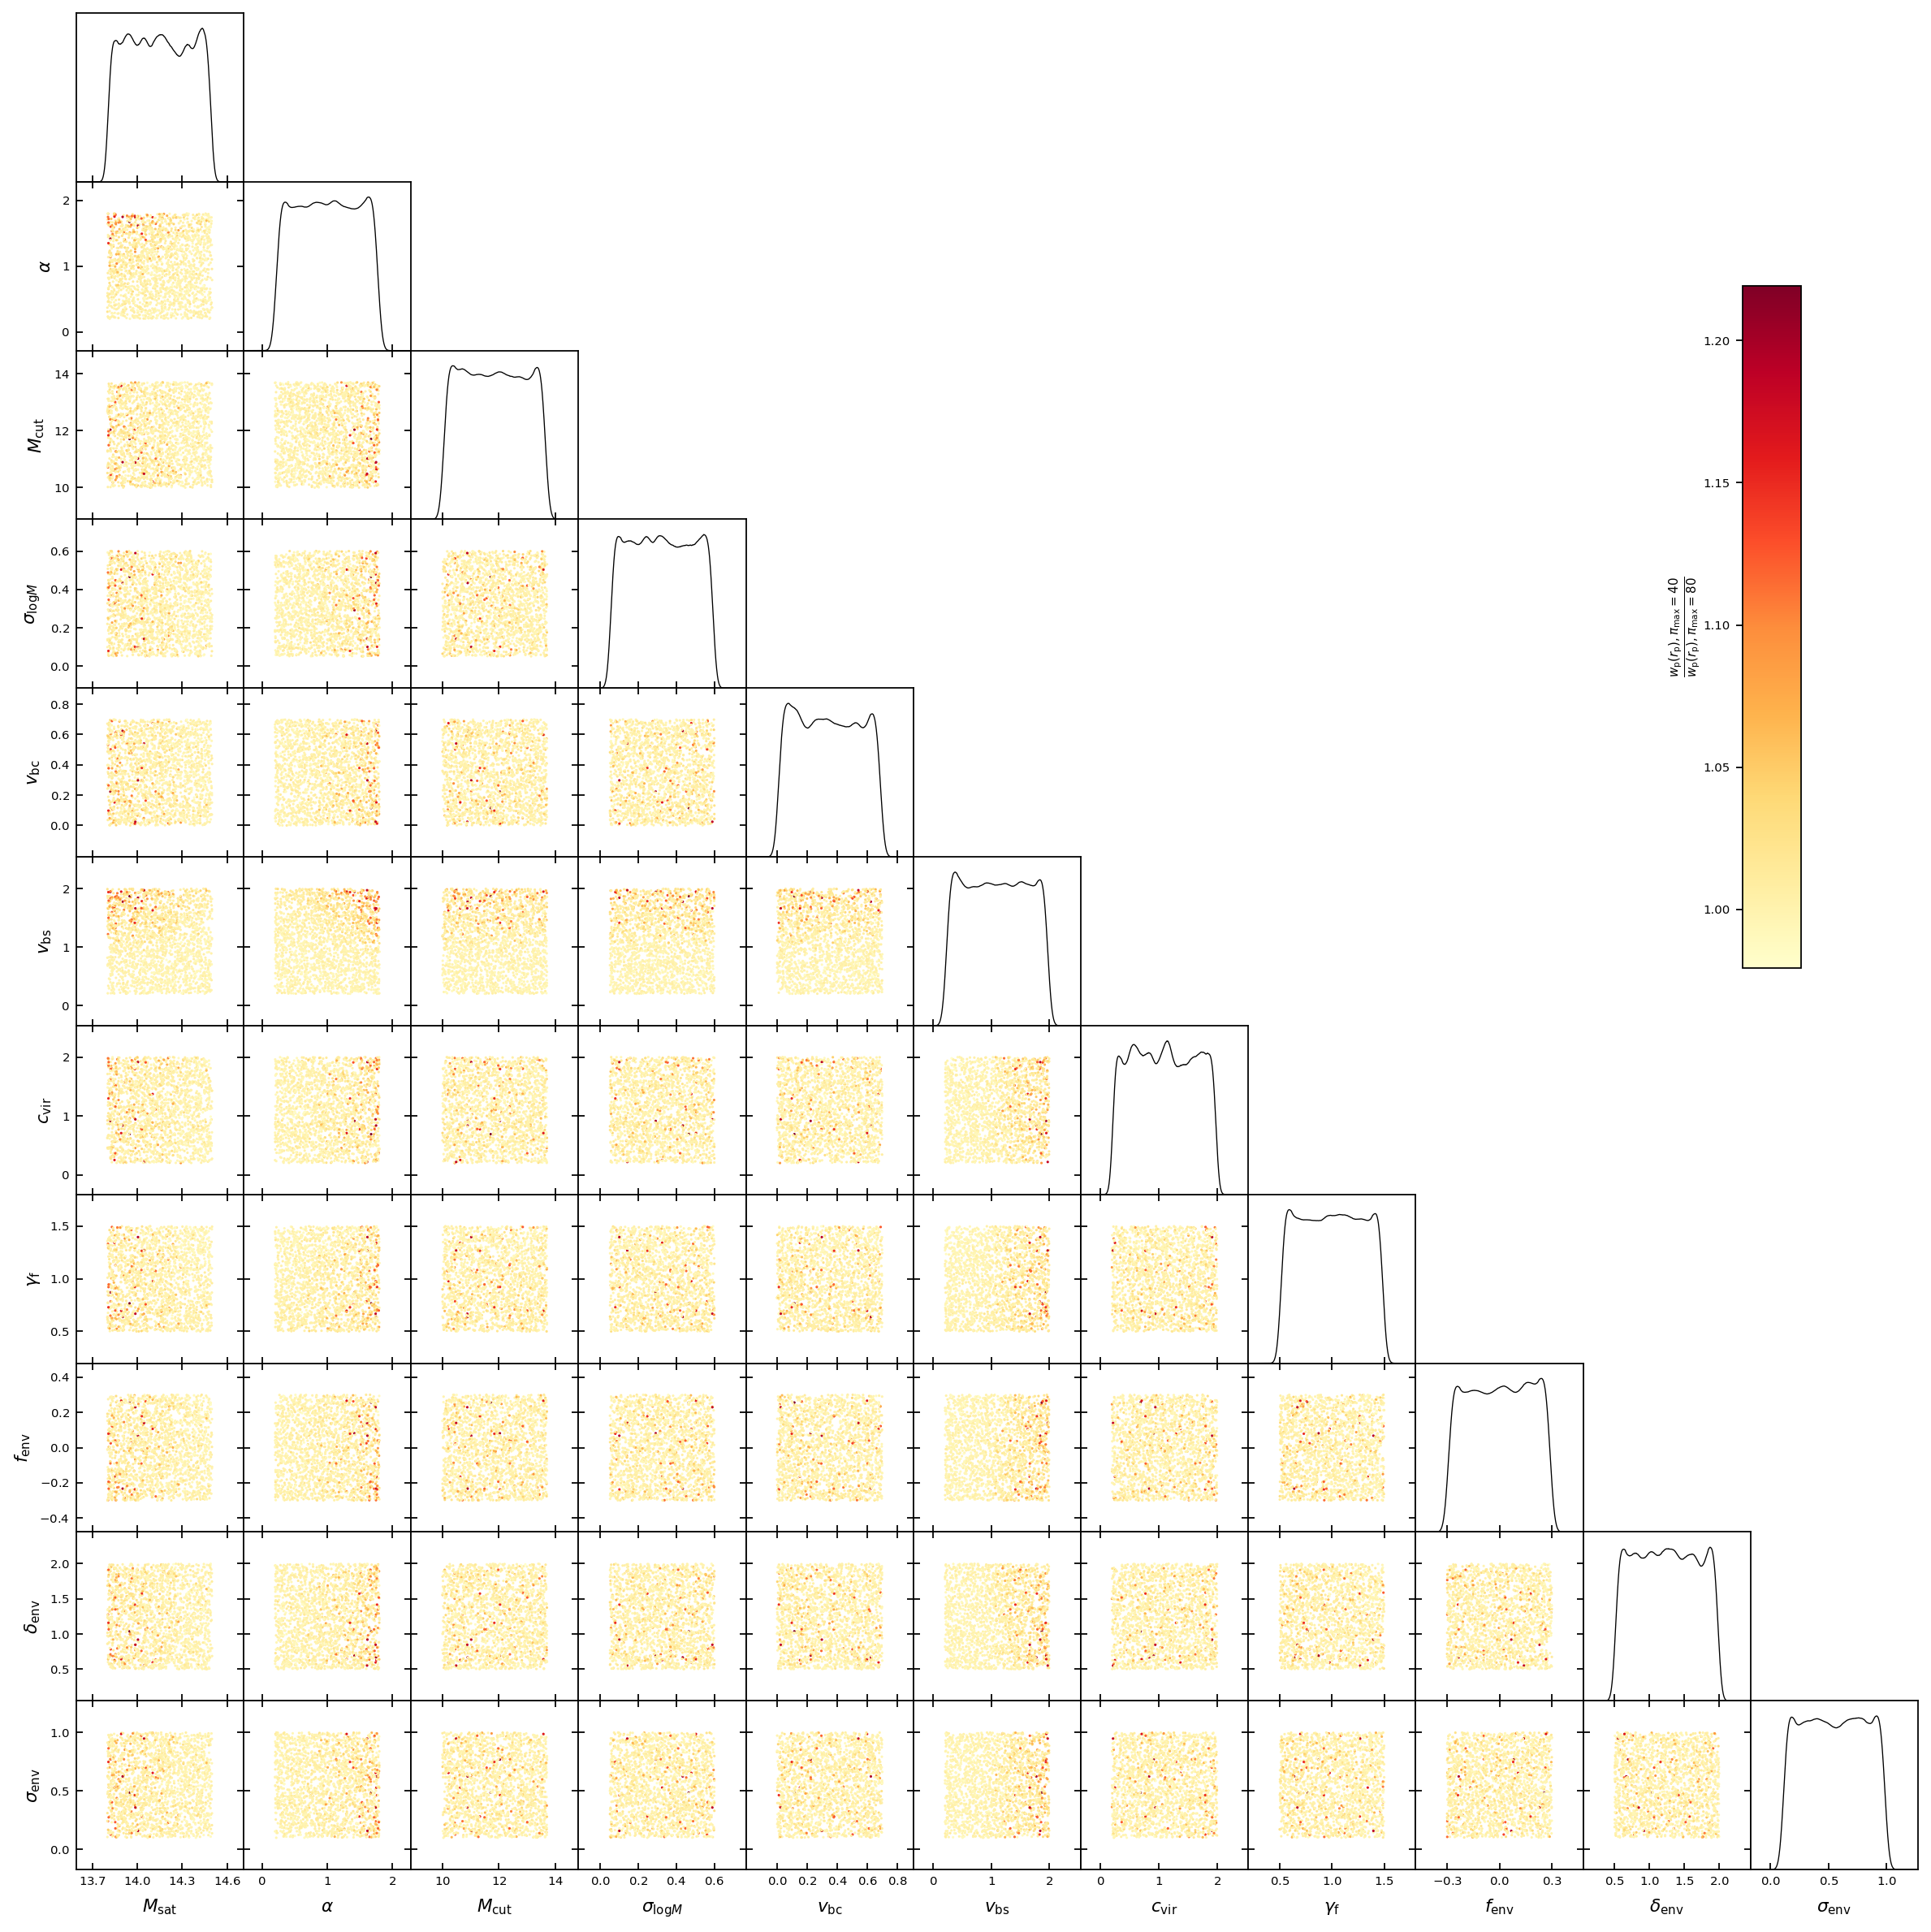

In [154]:
g = plots.get_subplot_plotter(width_inch=15)
#g = plots.get_subplot_plotter(subplot_size=2)
#g.settings.scaling_factor = 1
g.settings.colormap_scatter = 'YlOrRd'
print(hod_params_withratio.shape, len(hod_param_names_sub))
samples = MCSamples(samples=hod_params_withratio.T, names=hod_param_names_sub, labels=hod_labels)
print(hod_param_names_sub)
g.triangle_plot(samples, hod_param_names_sub[:-1], scatter_size=2,
                plot_3d_with_param='wp80/wp40')

The mocks with weirdly high values of wp at rp=1 with pi_max=80, compared to that at pi_max=40, tend to be mocks with:
- high values of sigma_8 -> high clustering amplitude
- high values of alpha (power law dependence of satellite occupation) -> more high-mass satellites
- low values of M_sat (typical mass of a halo to host one satellite) -> even small halos have satellites
- high values of v_bs (velocity dispersion of satellites compared to their host halos) -> satellites have larger velocities, so enhanced finger-of-god effect at small scales?

It seems that then as we integrate out to larger pi_max values, we are continuing to have positive correlations at r_p=1 scales, due to the large number of satellites at all mass scales. The satellites also have larger velocities, so at those scales we see an enhanced finger-of-god effect that stretches to larger pi_max values? 

# Test emulator

['_George_log', '_George_log']
[1.37567762e-04 2.23276041e-04 3.01280488e-04 1.73738144e-04
 8.96687108e-05 1.01233125e-04 1.62602524e-04 4.54715090e-04
 2.58545053e-03]
[0.00014771 0.00023692 0.00031378 0.00018946 0.00015495 0.00017927
 0.00031298 0.00064356 0.00509227]


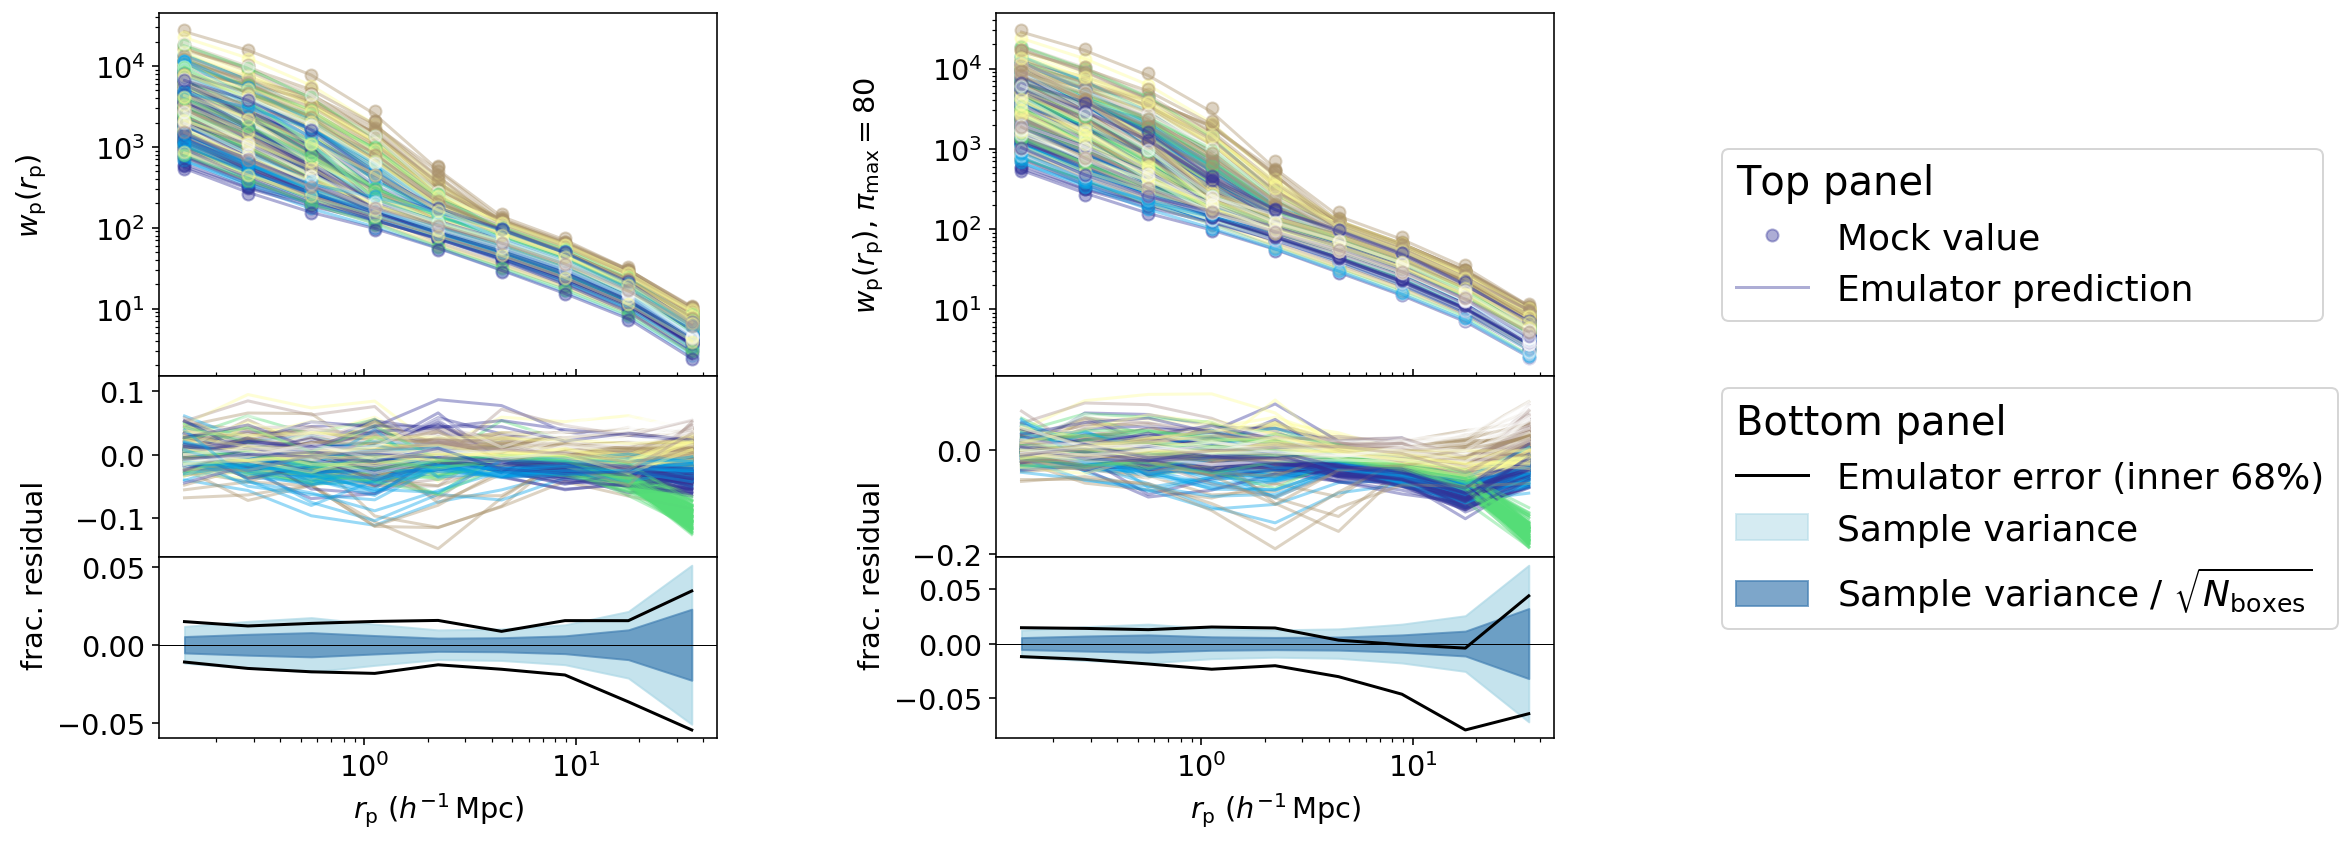

In [3]:
%matplotlib inline
statistics = ['wp', 'wp80']
train_tags = [f'_{get_fiducial_emu_name(s)}_{get_fiducial_emu_scaling(s)}' for s in statistics]
print(train_tags)
plotter.plot_accuracy_figure(statistics, train_tags)

[1.37567762e-04 2.23276041e-04 3.01280488e-04 1.73738144e-04
 8.96687108e-05 1.01233125e-04 1.62602524e-04 4.54715090e-04
 2.58545053e-03]
[1.37567762e-04 2.23276041e-04 3.01280488e-04 1.73738144e-04
 8.96687108e-05 1.01233125e-04 1.62602524e-04 4.54715090e-04
 2.58545053e-03]


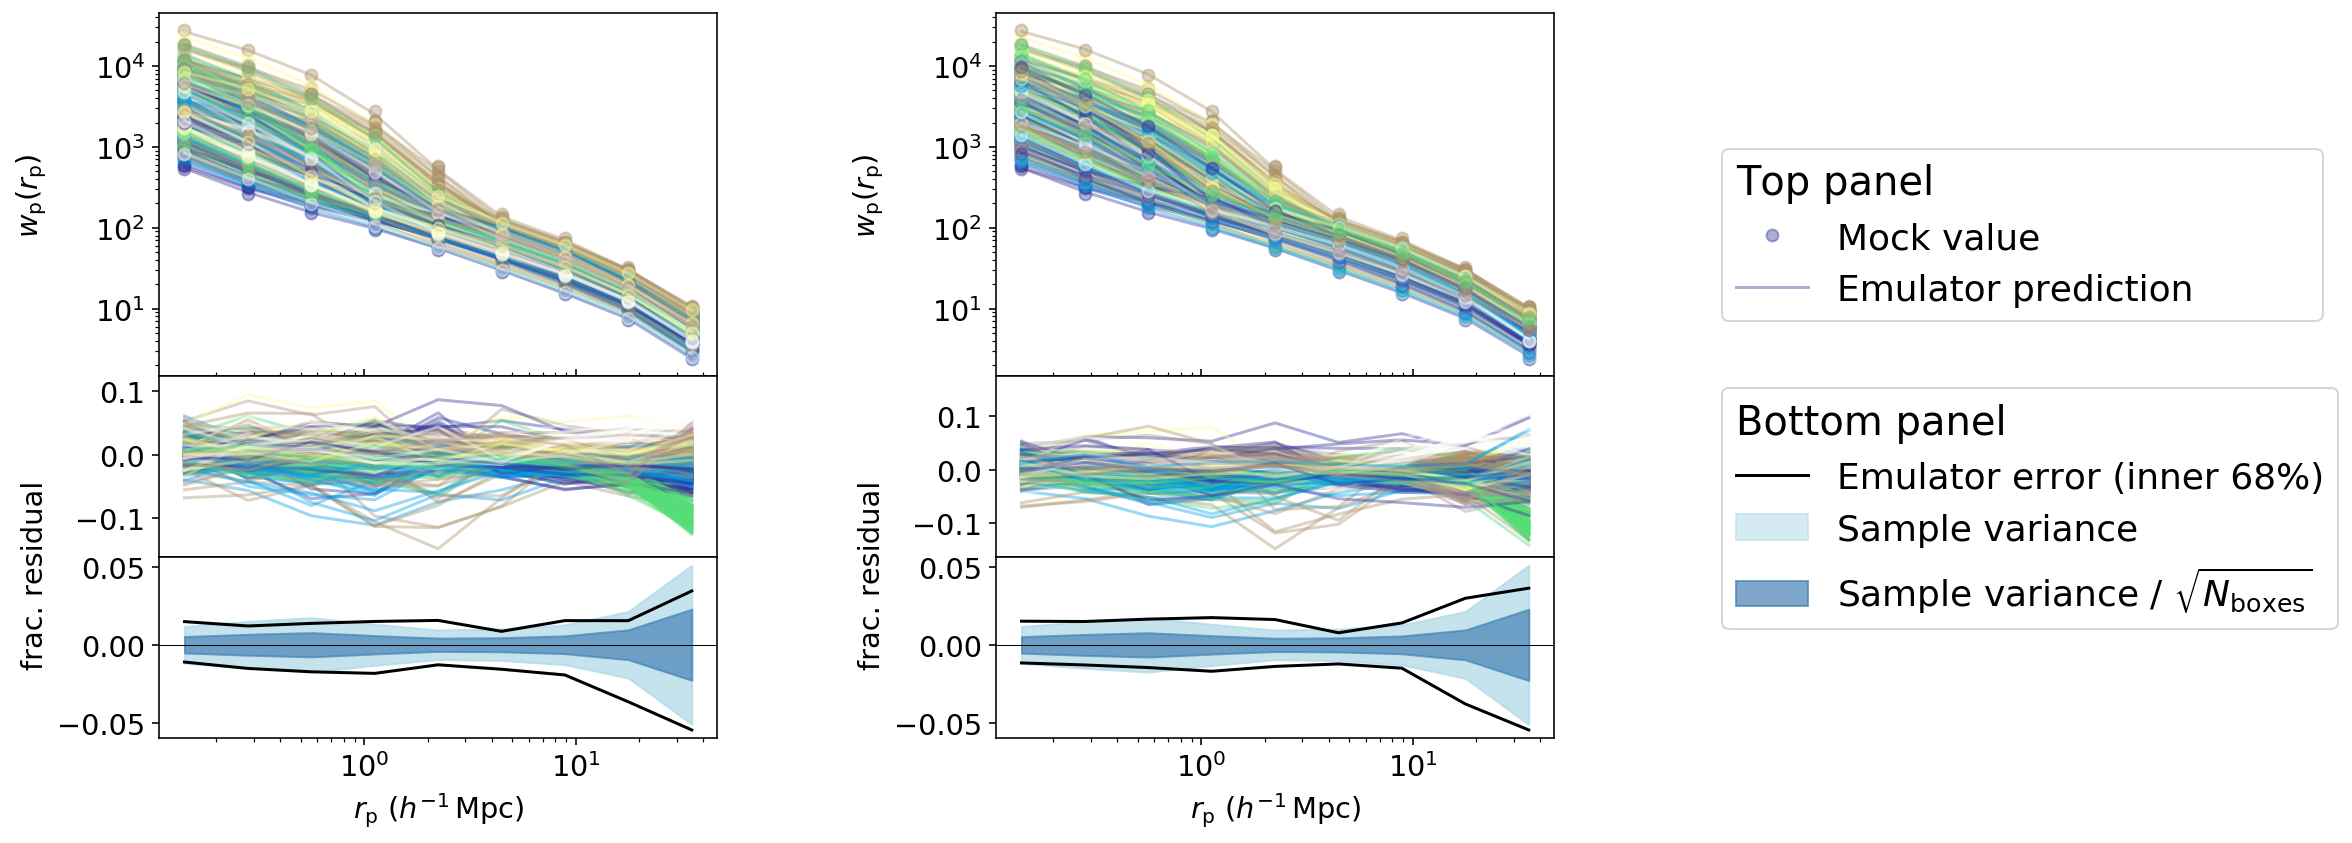

In [5]:
%matplotlib inline
statistics = ['wp', 'wp']
train_tags[-1] += '_errstdev'
plotter.plot_accuracy_figure(statistics, train_tags)

# chains

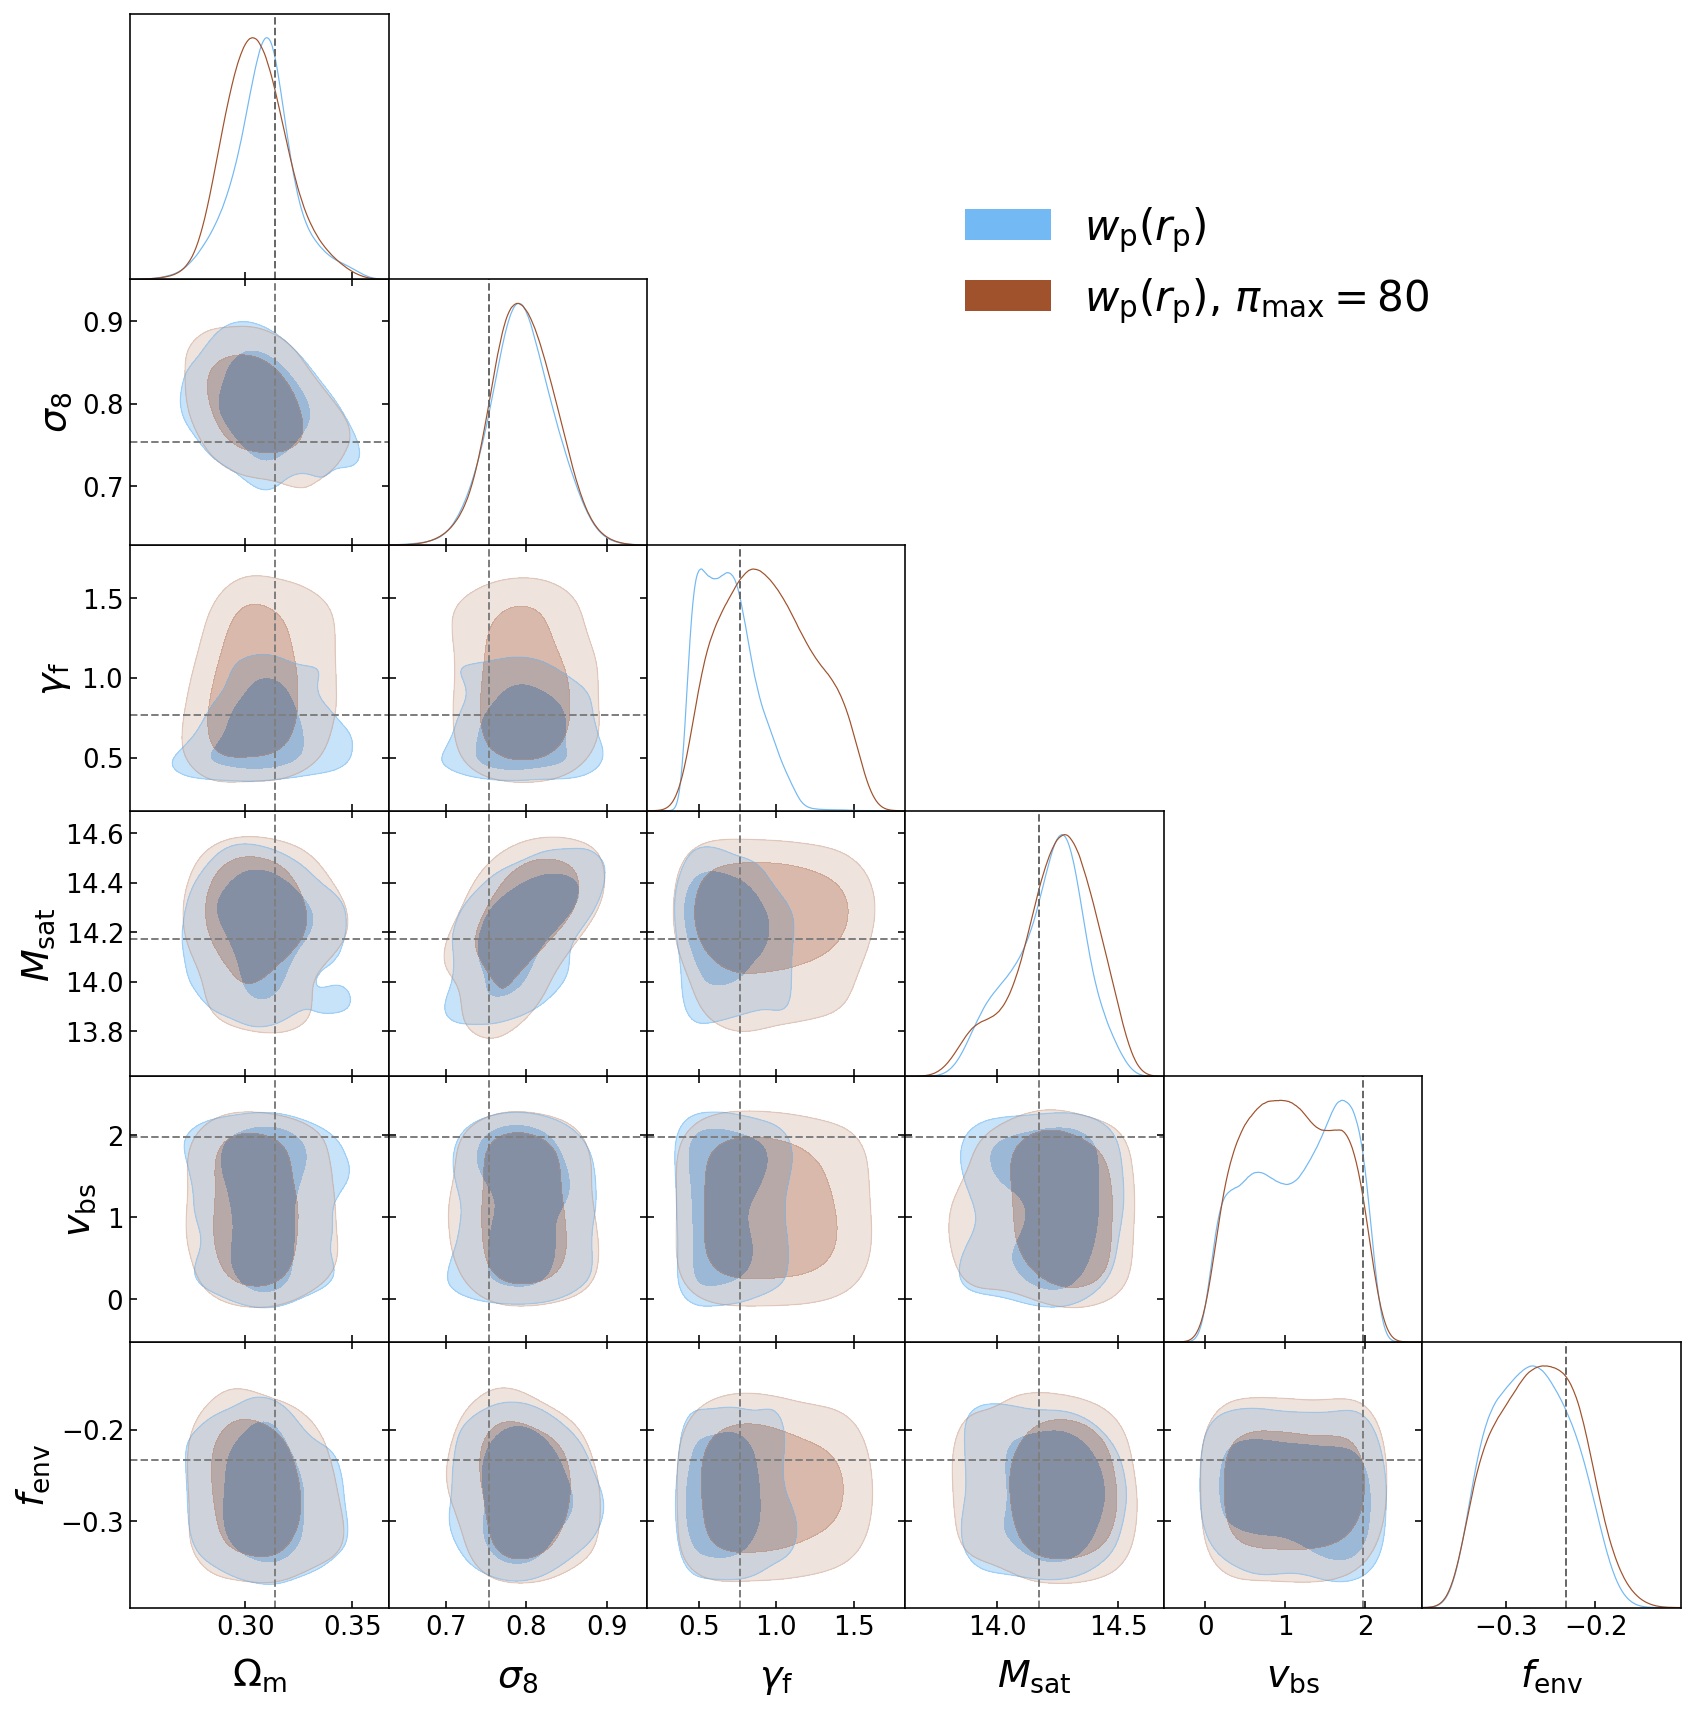

In [20]:
%matplotlib inline
chaintags = [
             'wp_c1h12_all_minscale0',
             'wp80_c1h12_all_minscale0',
            ]
stat_strs = ['wp', 'wp80']
labels = [stat_labels[s] for s in stat_strs]
colors = ['#73B9F3', 'sienna']
params_keymix = ['Omega_m', 'sigma_8', 'f', 'M_sat', 'v_bs', 'f_env']
g = plotter.plot_contours(chaintags, colors=colors,
                          legend_labels=labels, legend_loc=(0.56, 0.8),
                          legend_fontsize=24,
                          params_toplot=params_keymix)

In [15]:
id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)

chaintag_prior = 'prior'
prior_dict = utils.construct_results_dict(chaintag_prior)

results_dict_dir = '../data_products/results_dicts'
fn_results_dict_wp80 = f'{results_dict_dir}/results_dict_wp_wp80.npy'
results_dict_wp80 = np.load(fn_results_dict_wp80, allow_pickle=True).item()

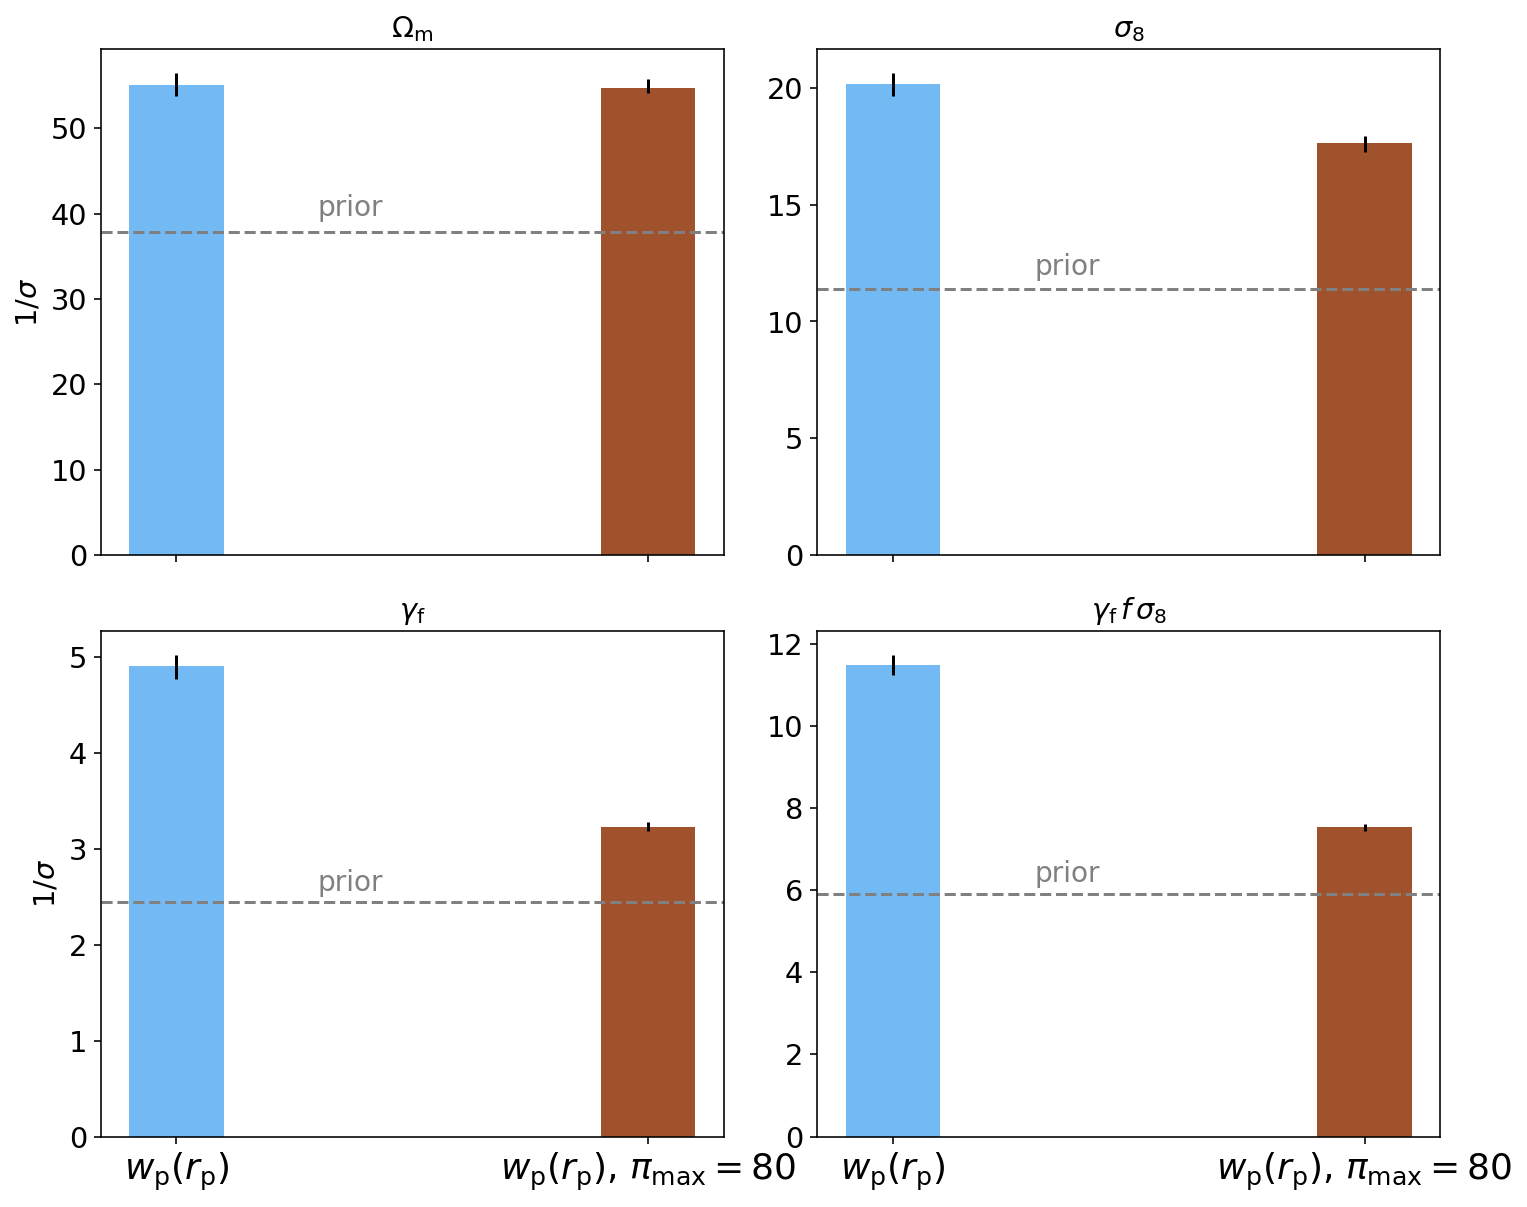

In [21]:
params_keydeliverable = ['Omega_m', 'sigma_8', 'f', 'fsigma8']
plotter.plot_uncertainty_figure(results_dict_wp80, prior_dict, params_keydeliverable, stat_strs, id_pairs, 
                                labels, colors)

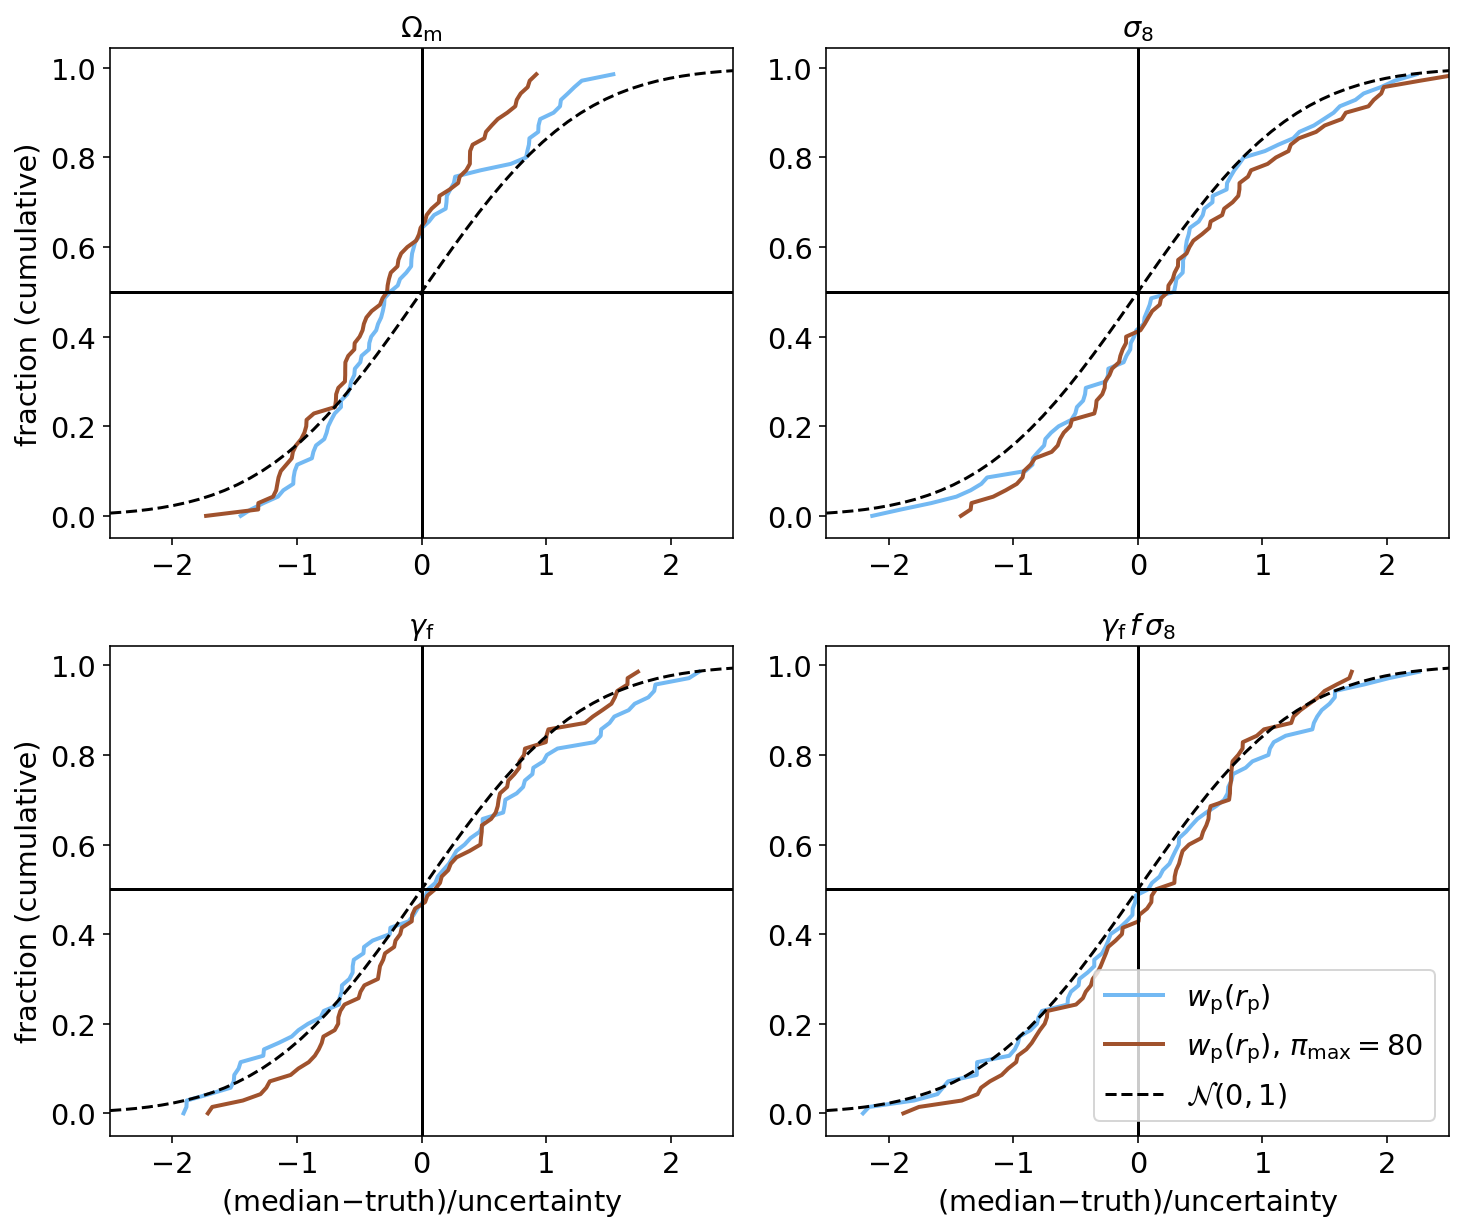

In [22]:
plotter.plot_cumulative_dist_figure(results_dict_wp80, params_keydeliverable, stat_strs, id_pairs, 
                                    labels, colors, divide_by_error=True)